In [9]:
# %%writefile tem_ip_linear.py
from SimPEG import *
from SimPEG import EM
from scipy.constants import mu_0
import numpy as np
import scipy.sparse as sp
from simpegEMIP.StretchedExponential import SEInvImpulseProblem, SESurvey
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
from simpegEMIP.TDEM import geteref, Problem3D_Inductive, Survey, getwe, get_we_eff
# from simpegem1d import DigFilter
# %matplotlib inline
# import matplotlib 
# matplotlib.rcParams["font.size"] = 14

# eta, tau, c = 0.1, 0.01, 0.5
cs, ncx, ncz, npad = 10., 25, 20, 18
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
sigmaInf = np.ones(mesh.nC) * 0.001
airind = mesh.gridCC[:,2]>0.
actinds = ~airind
# layerind = np.logical_and(mesh.gridCC[:,2]<-50, mesh.gridCC[:,2]>-100.)
layerind = (np.logical_and(mesh.gridCC[:,2]<-50, mesh.gridCC[:,2]>-100.)) & (mesh.gridCC[:,0]<100.)
sigmaInf[airind] = 1e-8
sigmaInf[layerind] = 0.01
eta = np.zeros(mesh.nC)
eta[layerind] = 0.5
tau = np.ones(mesh.nC) * 0.005
c = np.ones(mesh.nC) * 0.5

actmapeta = Maps.InjectActiveCells(mesh, actinds, 0.)
actmaptau = Maps.InjectActiveCells(mesh, actinds, 0.005)
actmapc = Maps.InjectActiveCells(mesh, actinds, 0.5)

wires = Maps.Wires(('eta', actmapeta.nP), ('tau', actmapeta.nP), ('c', actmapeta.nP))

taumap = actmaptau*wires.tau
etamap = actmapeta*wires.eta
cmap = actmapc*wires.c

m = np.r_[eta[actinds], tau[actinds], c[actinds]]

rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])
dt = 2e-5
# rx_ramp = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.009), 51)+dt, 'z')
# src_ramp = EM.TDEM.Src.CircularLoop([rx_ramp], waveform=EM.TDEM.Src.RampOffWaveform(offTime=dt), loc=srcloc)
rx_ramp = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.009), 51), 'z')
src_ramp = EM.TDEM.Src.CircularLoop([rx_ramp], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc)
src_ramp1 = EM.TDEM.Src.CircularLoop([rx_ramp], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc)
survey_ramp = EM.TDEM.Survey([src_ramp, src_ramp1])
prb_em_ramp = EM.TDEM.Problem3D_e(mesh, sigmaMap=Maps.IdentityMap(mesh))
# prb_em_ramp.verbose = True
prb_em_ramp.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
# prb_em_ramp.timeSteps = [(1e-6, 5), (1e-5, 5), (5e-5, 10), (1e-4, 10), (5e-4, 10), (1e-3, 20)]
prb_em_ramp.Solver = PardisoSolver
prb_em_ramp.pair(survey_ramp)
# m = np.r_[sigmaInf, etavec, np.log(tauvec), cvec]
F_ramp = prb_em_ramp.fields(sigmaInf)
data_ramp = survey_ramp.dpred(sigmaInf, f=F_ramp)
cur = []
for t in prb_em_ramp.times:
    cur.append(src_ramp.waveform.eval(t))
cur = np.hstack(cur)

rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])
dt = 1e-6
survey_ip_ramp = Survey([src_ramp, src_ramp1])
e = F_ramp[:, 'eSolution', :]
eref_ramp = geteref(e, mesh, option="max") 
prb_ip_ramp = Problem3D_Inductive(
    mesh, 
    sigmaInf=sigmaInf, 
    etaMap=etamap, 
    tauMap=taumap, 
    cMap=cmap, 
    actinds = ~airind,
    wave_option = "impulse"
#     tlags = [0, dt],     
)
prb_ip_ramp.Solver = PardisoSolver
prb_ip_ramp.pair(survey_ip_ramp)
prb_ip_ramp.set_eref(eref_ramp)
prb_ip_ramp.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
# prb_ip_ramp.timeSteps = [(1e-6, 5), (1e-5, 5), (5e-5, 10), (1e-4, 10), (5e-4, 10), (1e-3, 20)]
prb_ip_ramp.J = prb_ip_ramp.getJ()
prb_ip_ramp.we = get_we_eff(e, eref_ramp, prb_ip_ramp.J, mesh, actinds)
ip_ramp_approx = survey_ip_ramp.dpred(m)

>> Compute Sensitivity matrix
 2 / 2

In [10]:
# def get_we_eff(e, eref, J, mesh, active):
#     # Here we assume dimension of J: [nSrc x nC]
#     nSrc = e.shape[1]
#     ntime = e.shape[2]
#     we_eff = np.zeros((mesh.nE, nSrc))
#     J_sum_src = (J**2).sum(axis=0)
#     we_cc_eff = np.zeros((mesh.nC, ntime))
#     for iSrc in range(nSrc):
#         we_cc = getwe(e[:, iSrc, :], eref[:, iSrc], mesh)
#         a_ik = J[iSrc, :]**2 / J_sum_src
#         we_cc_eff[actinds] += Utils.sdiag(a_ik) * we_cc[actinds, :]
#     return we_cc_eff

In [11]:
# inds_cc = (mesh.gridCC[:,0]<200.) & (mesh.gridCC[:,2]>-200.) & (mesh.gridCC[:,2]<0.)
# pts=mesh.gridCC[inds_cc,:]
# inds = Utils.closestPoints(mesh, pts)
# for ind in inds:
#     plt.semilogx(prb_em_ramp.times, we[ind,:], 'k-', alpha=0.1)

In [12]:
# temp = mesh.aveE2CC*eref_ramp[:,1]
# temp[temp<0.] = 1e-20
# mesh.plotImage(np.log10(abs(temp)), mirror=True, )
# plt.xlim(-200, 200)
# plt.ylim(-200, 0)

In [13]:
Pdt = prb_em_ramp.timeMesh.getInterpolationMat(survey_ip_ramp.times, "CC")*prb_em_ramp.timeMesh.faceDiv

In [14]:
# mesh.plotImage(prb_ip_ramp.Peta[:,39], mirror=True, )
# plt.xlim(-200, 200)
# plt.ylim(-200, 0)

In [15]:
# temp = prb_ip_ramp.J.dot(prb_ip_ramp.actMap.P.T*prb_ip_ramp.Peta)

In [16]:
data = np.load("data.npy")
data_ramp = np.load("data_ramp.npy")
data_vtem = np.load("data_vtem.npy")

data_em = np.load("dataem.npy")
data_em_ramp = np.load("dataem_ramp.npy")
data_em_vtem = np.load("dataem_vtem.npy")
ip = data - data_em
ip_ramp = data_ramp - data_em_ramp
ip_vtem = data_vtem - data_em_vtem

In [17]:
data_ramp_approx = data_em + ip_ramp_approx.reshape((2, survey_ip_ramp.times.size))[0,:]

In [14]:
# J = np.load("J.npy")

In [15]:
# plt.semilogy(abs(J[actinds]))
# plt.semilogy(abs(prb_ip_ramp.J.flatten())[actinds], '.')

In [16]:
# plt.loglog(rx_ip_ramp.times, -data_ramp, 'k')
# plt.loglog(rx_ip_ramp.times, data_ramp, '--k')
# plt.loglog(rx_ip_ramp.times, -data_em_ramp, 'b-')
# plt.loglog(rx_ip_ramp.times, ip_ramp, 'r-')
# plt.plot(rx_ip_ramp.times, ip_ramp_approx, 'r.')

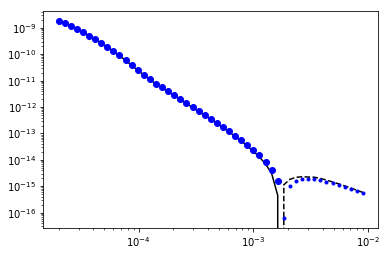

In [18]:
plt.loglog(rx_ramp.times, -data, 'k')
plt.loglog(rx_ramp.times, data, '--k')
# plt.loglog(rx_ramp.times, -data_ramp, 'k')
# plt.loglog(rx_ramp.times, data_ramp, '--k')

plt.loglog(rx_ramp.times, -data_ramp_approx, 'bo')
plt.loglog(rx_ramp.times, data_ramp_approx, 'b.')